In [22]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from time import time

from numba import njit

## Smoluchowski coagulation equation

The coagulation equation describes how particles stick together to form larger particles. This process is also sometimes called aggregation or flocculation. Examples include formation of rain droplets or ice crystals in clouds, formation of mineral "flocs" in the ocean, or formation of planets from dust.

The equation exists in both continuous and discrete forms, depending on if the distribution of particle sizes is continuous or discrete. We will deal with the discrete case, and solve it with a stochastic particle model.

The discrete form of the equation reads

$$ \frac{\mathrm{d} n_i}{\mathrm{d} t} = \frac{1}{2} \sum_{j=1}^{i-1} K(m_{i-j}, m_j) \, n_j \, n_{i-j} - \sum_{j=1}^{\infty} K(m_i, m_j) \, n_i \,n_j, $$

where $n_i$ is the number of particles of mass $m_i$, and $K(m_i, m_j)$ is called the kernel. It represents the probability, per particle pair, that two particles of mass $m_i$ and $m_j$ collide and stick together to form a new, larger particle of mass $m_i + m_j$.

The two terms on the right-hand side of the equation represents first the rate at which particles of mass $m_i$ are created, and second the rate at which particles of mass $m_i$ are removed. Creation happens when two particles of masses $m_i - m_j$ and $m_j$ collide and stick together, since this will create a new particle with mass $m_i$. Removal happens when a particle of mass $m_i$ collides and reacts with any other particle, as this will create a new particle with mass larger than $m_i$.

### The kernel

The kernel, also called the collision kernel, depends on the context. For example in cloud physics, the kernel would take into account Brownian motion, vertical settling speeds and air turbulence, which makes the kernel a function of both particle mass (and size) and external factors that may change with time. 

For some special cases, such as the kernel being a constant, analytical solutions of the coagulation equation exist.

## Stochastic particle implementation

We will model the equation with an ensemble of particles, assumed to be uniformly distributed throughout some volume, and with a constant kernel. All particles start out with the same mass, $m$, which means that all aggregates consisting of $i$ primary particles will have a mass equal to $m_i = i \times m$.

With a constant kernel, $K$, the rate at which particles of masses $m_i$ and $m_j$ collide is $K \, n_i \, n_j$, which means that for each such pair of particles, the probability of a reaction happening during an interval $\Delta t$ is 

$$ p = 1 - \mathrm{e}^{-\Delta t K}. $$

We will implement this by considering all pairs of particles, and checking for a reaction by drawing a random number $r$, and letting the particles react if $r < p$ (Bernoulli trials). If two particles react, we remove one of them, and give the other particle a new mass equal to the sum of the two old masses.

In [21]:
# Compiling this function with numba, as it contains a double for loop,
# which is quite slow.
@njit
def coagulate_dense(M, dt):
    # This function calculates coagulation for one timestep of duration dt
    # Inputs:
    # M  : An 1D array of masses.
    #    The length of this array is the original number of particles.
    #    Coagulation events reduce the number of particles.
    # dt : The duration of the timestep
    Np = len(M)
    K = 1e-5 # Constant collision kernel
    # Check all pairs of particles once
    for i in range(Np):
        # Only check for reactions if particle i is valid
        if M[i] > 0:
            for j in range(i-1): # Do not react with self
                # Check that particle j is also still valid
                if M[j] > 0:
                    # Probability of reacting
                    p = 1 - np.exp(-dt*K)
                    # Uniform random number
                    r = np.random.random()
                    # If reaction occurs, calculate new particle size
                    # Assign new size to one particle, and mark the other as removed
                    if r < p:
                        M[i] = M[i] + M[j]
                        M[j] = -999 # Using -999 to mark invalid particles
    return M

def experiment_dense(M0, Tmax, dt):
    '''
    Run the model.

    M0:      Initial mass of particles (len(M0) = Np)
    Tmax:    Total duration of the simulation
    dt:      Timestep
    '''

    # Number of particles
    Np = len(M0)
    # Number of timesteps
    Nt = int(Tmax / dt) + 1
    # Array to store output
    M = np.zeros((Nt, Np))
    M[0,:] = M0.copy()
    
    # Time loop
    for i in trange(1, Nt):
        # Reaction
        M[i,:] = coagulate_dense(M[i-1,:].copy(), dt)

    t = np.linspace(0, Tmax, M.shape[0])
    return M, t

# Compiling this function with numba, as it contains a double for loop,
# which is quite slow.
@njit
def coagulate_gillespie(M, dt):
    # This function steps forward in time by an amount no less than dt
    # Inputs:
    # M  : An 1D array of masses.
    #    The length of this array is the original number of particles.
    # dt : The duration to simulate

    K = 1e-5 # Constant collision kernel
    t = 0
    while t < dt:
        # Calculate number of particles
        Npart = np.sum(M > 0)
        Npair = Npart * (Npart - 1) / 2
        # Draw random time of next collision
        tau = np.random.exponential(scale = 1/(Npair * K))
        # Draw two random particles
        # (all particles equally likely with constant kernel)
        inds = np.arange(len(M))[M > 0]
        i, j = np.random.choice(inds, size=2, replace=False)
        # Assign new size to one particle, and mark the other as removed
        M[i] = M[i] + M[j]
        M[j] = -999 # Using -999 to mark invalid particles
        # Increment time
        t += tau
    return M, t

def experiment_gillespie(M0, Tmax, dt):
    '''
    Run the model.

    M0:      Initial mass of particles (len(M0) = Np)
    Tmax:    Total duration of the simulation
    dt:      Timestep
    '''

    # Number of particles
    Np = len(M0)
    # Number of timesteps
    Nt = int(Tmax / dt) + 1
    # Array to store output
    M = [M0,]
    t = [0.,]
    
    # Time loop
    while t[-1] < Tmax:
        # Reaction
        M_, dt_ = coagulate_gillespie(M[-1].copy(), dt)
        M.append(M_)
        t.append(t[-1] + dt_)

    return M, t

In [30]:
# Simulation time and timestep
Tmax = 50
dt = 0.5
# Number of particles 
Np = 40000
# Initial mass distribution, all particles have the same mass (m=1)
M0 = np.ones(Np)

# Run simulation
tic = time()
M_d, t_d = experiment_dense(M0, Tmax, dt)
toc = time()
print(f'Double-for took {toc-tic:.3f} seconds')

# Run simulation
tic = time()
M_g, t_g = experiment_gillespie(M0, Tmax, dt)
toc = time()
print(f'Gillespie took {toc-tic:.3f} seconds')

  0%|          | 0/100 [00:00<?, ?it/s]

Double-for took 109.730 seconds
Gillespie took 18.095 seconds


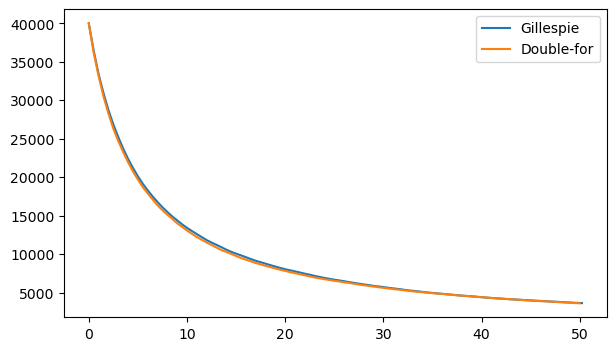

In [31]:
fig = plt.figure(figsize=(7,4))

plt.plot(t_g, [np.sum(M_ > 0) for M_ in M_g], label='Gillespie')
plt.plot(t_d, [np.sum(M_ > 0) for M_ in M_d], label='Double-for')

plt.legend()

In [33]:
M_g = np.array(M_g)

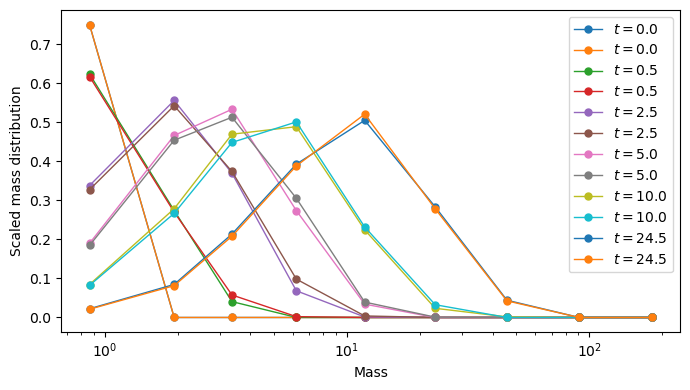

In [38]:
# Create logspaced bins
bins = np.array([0.5, 1.5, 2.5, 4.5, 8.5, 16.5, 32.5, 64.5, 128.5, 256.5])

# Find midpoints of the bins (on log scale)
mids = np.sqrt(bins[1:]*bins[:-1])

# Plot a few different timesteps
fig = plt.figure(figsize=(7, 4))
Nt = M_g.shape[0]
for it in [0, 1, 5, 10, 20, 49]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M_g[it,:][M_g[it,:]>0], bins=bins)
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')

    h, _ = np.histogram(M_d[it,:][M_d[it,:]>0], bins=bins)
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')


plt.legend()
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Scaled mass distribution')
plt.tight_layout()

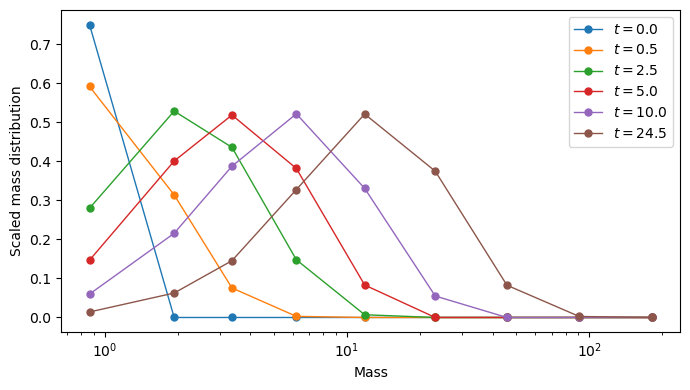

In [119]:
# Create logspaced bins
bins = np.array([0.5, 1.5, 2.5, 4.5, 8.5, 16.5, 32.5, 64.5, 128.5, 256.5])

# Find midpoints of the bins (on log scale)
mids = np.sqrt(bins[1:]*bins[:-1])

# Plot a few different timesteps
fig = plt.figure(figsize=(7, 4))
Nt = M.shape[0]
for it in [0, 1, 5, 10, 20, 49]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M[it,:][M[it,:]>0], bins=bins)
    # Plot particle counts times mass squared,
    # (see Figure is Wetherill)
    # and scaled by bin width and particle number
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')


plt.legend()
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Scaled mass distribution')
plt.tight_layout()

# Analytical solution for constant kernel

The function defined below combines Eqs. (6), (7) and (8) from Wetherill (1990), to give analytical solutions for the special case of constant kernel, and with the assumption that all particles start out with identical mass, $m$. This means that at all times, the mass of any particle will be $mk$, where $k = 1, 2, 3, ...$

https://www.sciencedirect.com/science/article/pii/001910359090086O

In [120]:
def nk(k, t, Np0, alpha=1e-5):
    # This function calculates the number of particles
    # with mass m*k at time t
    # Inputs:
    # k   : "Mass" (really the mass is m*k, but the m doesn't matter in this case)
    # t   : Time for which to calculate
    # Np0 : The initial number of particles (all of equal mass m)
    eta = alpha*Np0*t              # Eq. (7) in Wetherill, dimensionless time
    f = 1/(1 + eta/2)              # Eq. (6) in Wetherill
    return Np0*f**2 * (1-f)**(k-1) # Eq. (8) in Wetherill

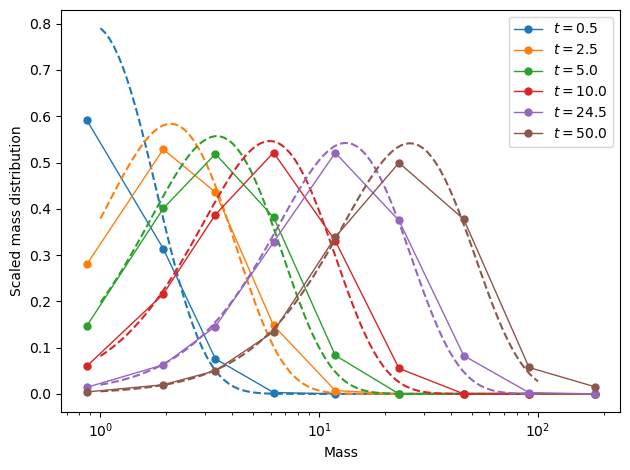

In [121]:
# array of masses for which to plot the analytical solution
ms = np.logspace(0, 2, 100)

# Plot a few different timesteps
Nt = M.shape[0]
for it in [1, 5, 10, 20, 49, 100]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M[it,:][M[it,:]>0], bins=bins)
    # Plot particle counts times mass squared,
    # (see Figure is Wetherill)
    # and scaled by bin width and particle number
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')
    # Plot analytical solution for the same time (output timestep times time index)
    # and plotting for a larger number of masses, to get smooth curve
    plt.plot(ms, ms**2 * nk(ms, dt*it, Np) / Np, '--', c = l.get_color())


plt.legend()
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Scaled mass distribution')
plt.tight_layout()

## Combining the coagulation equation with transport

In applications such as modelling growth of rain droplets in a cloud, or flocculation of mineral particles in the ocean, we have to combine the coagulation equation with some sort of transport model, for example diffusion and settling, where the settling velocity depends on the variable particle size.

We can implement the transport part as a normal SDE, and then add on the coagulation part, taking into account that particles can only aggregate with nearby particles. One possible method is to introduce a grid of cells, and only let particles aggregate with other particles in the same cell.

Below, we see an example of this, where we consider vertically settling rain droplets, and transport is governed by the equation

$$ \mathrm{d}z_t = v(r) \, \mathrm{d}t + \sqrt{2K} \, \mathrm{d}W_t, $$

where $K$ is the (constant) diffusivity and $v(r)$ is the settling velocity. The droplet radius, $r$, is a found from the mass of a droplet by assuming a spherical shape and known density:
$$ r = \sqrt[3]{\frac{3m}{4 \pi \rho}}. $$
We will assume that the settling velocity is just some constant times $r^2$ (Stokes' drag).

In [204]:
def a(X, t):
    # Assuming here that X has shape (2, Np)
    # where X[0,:] is position
    # and X[1,:] is mass (which remains unchanged by the SDE part of the solver)
    # Calculate radius from mass
    rho = 1 # Density of water
    vk  = 1 # Velocity prefactor
    r = (3*X[1,:] / (4*np.pi*rho))**(1./3)
    dX = np.zeros_like(X)
    dX[0,:] = -vk * r**2
    return dX

def b(X, t):
    # Assuming here that X has shape (2, Np)
    # where X[0,:] is position
    # and X[1,:] is mass (which remains unchanged by the SDE part of the solver)
    # Calculate radius from mass
    K = 1e-2
    dX = np.zeros_like(X)
    dX[0,:] = np.sqrt(2*K)
    return dX

def run_experiment(X0, M0, Tmax, dt, a, b, solver):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Np = len(X0)
    Nt = int(Tmax/dt) + 1
    # value to flag removed particles
    flag = -999
    # Arrays to track solution
    X = np.zeros((Nt, 2, Np)) + flag
    X[0,0,:] = X0
    X[0,1,:] = M0
    t = 0
    for n in trange(1, Nt):
        
        # Mask removed particles
        mask = ~(X[n-1,0,:] == flag)
        
        # Call solver to make transport step, applying only to non-removed particles
        X[n,:,mask] = EM(X[n-1,:,mask].T, t, dt, a, b).T
        
        # Spatial bins to determine local neighbourhood
        # for coagulation part
        bins = np.linspace(np.amin(X[n,0,mask]), np.amax(X[n,0,mask]), 25)
        for i in range(len(bins)-1):
            
            # Identify particles that are inside a bin
            mask2 = (bins[i] <= X[n,0,:]) & (X[n,0,:] < bins[i+1])
            # Apply coagulation to those particles
            X[n,1,mask2] = coagulate_dense(X[n,1,mask2].copy(), dt)
            
        # For all particles that were removed in coagulation, set position to flag value
        X[n,0,:] = np.where(X[n,1,:] == flag, flag, X[n,0,:])

        t += dt
    return X[:,0,:], X[:,1,:]

In [205]:
Np = 100000
X0 = np.random.normal(loc=100, scale=10, size=Np)
M0 = 1. * np.ones(Np)

Tmax = 50
dt = 0.5
X, M = run_experiment(X0, M0, Tmax, dt, a, b, EM)

  0%|          | 0/100 [00:00<?, ?it/s]

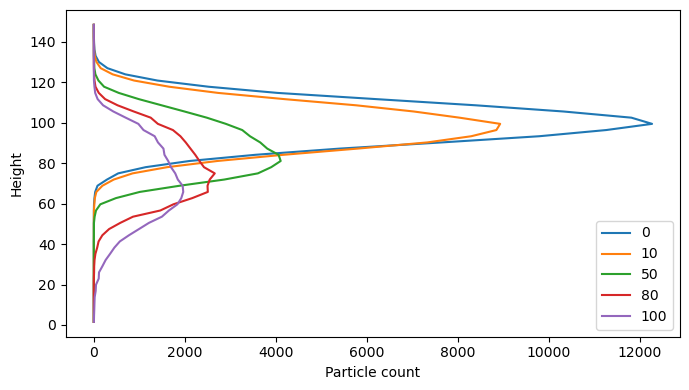

In [206]:
fig = plt.figure(figsize = (7,4))

bins = np.linspace(0, 150, 50)
mids = bins[:-1] + (bins[1]-bins[0])/2

for it in [0, 10, 50, 80, 100]:
    h, _ = np.histogram(X[it,:][X[it,:] > -900], bins=bins)
    plt.plot(h, mids, label=it)
    
plt.legend()
plt.xlabel('Particle count')
plt.ylabel('Height')
plt.tight_layout()

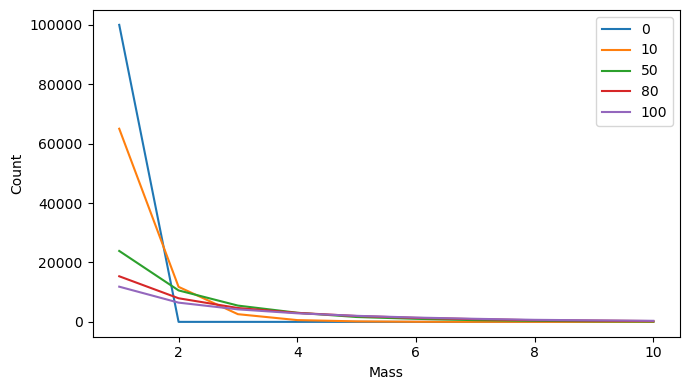

In [207]:
fig = plt.figure(figsize = (7,4))

bins = np.linspace(0.5, 10.5, 11)
mids = bins[:-1] + (bins[1]-bins[0])/2

for it in [0, 10, 50, 80, 100]:
    h, _ = np.histogram(M[it,:][X[it,:] > -900], bins=bins)
    plt.plot(mids, h, label=it)
    
plt.legend()
plt.xlabel('Mass')
plt.ylabel('Count')
plt.tight_layout()